In [1]:
import math
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Определяем константы для 76As и 37Ar

In [77]:
Q_EC_76As=0.9233 #in MeV
Z_76As=33
log_ft_76As=4.6

Q_EC_37Ar=0.81387 #in MeV
Z_37Ar=18
log_ft_37Ar=5.1

g_a_g_v=1.297 #ratio of vector and axial coupling constants

In [54]:
def Q_k_func(E_k, Q_EC):
    #Считаем порог реакции, E_k - энергия возбужденного состояния
    #E_k in KeV
    return Q_EC+E_k/1000

Привиденная энергия вылетающего электрона: $\epsilon_e = \frac{E_{\nu}-Q_k}{m_e} + 1$

In [55]:
def e_e_func(E_nu, E_k, Q_EC):
    #Считаем привиденную энергию вылетающего электрона. Если энергия налетающего нейтрино E_nu
    #меньше порога, возвращаем 0 для обнуления итогового сечения
    #E_nu in MeV
    q=Q_k_func(E_k, Q_EC) #порог реакции
    if E_nu>q: return 1+(E_nu-q)/0.511
    else: return 0 

Привиденный импульс электрона: $\pi_e=\sqrt{\epsilon_e^2 -1}$

In [56]:
def Pi_e_func(e_e):
    #Привиденный импульс электрона, вычисляется через привиденную энергию; ** означает степень  
    if e_e>1: return math.sqrt(e_e**2 - 1)
    else: return 0

Ферми функция по Инжечику: $F(Z, {\epsilon}_e)= \frac{y}{1-e^{-y}}$, где $ {y} = \frac{2{\pi}Z\alpha}{\pi_e} $

In [57]:
def Columb_func(Pi_e, Z):
    #ферми функция по Инжечику
    if Pi_e>0:
        y_k=(2*math.pi*Z)/(Pi_e*137)
        return y_k/(1-math.exp(-y_k))
    else: return 0

Ферми функция по Бакалу: $F(Z, {\epsilon}_e)= \frac{y}{1-e^{-y}}$, где $ {y} = \frac{2{\pi}Z\alpha \epsilon_e}{\pi_e} $

In [58]:
def Columb_func_Bahcall(Pi_e, Z, e_e):
    #ферми функция по Бакалу
    if Pi_e>0:
        y_k=(2*math.pi*Z*e_e)/(Pi_e*137)
        return y_k/(1-math.exp(-y_k))
    else: return 0

Сечение по Инжечику $\sigma_k=\frac{0.2625}{10^{log ft}}\frac{2J_k+1}{2J_i+1} \epsilon_e \pi_e F(Z, \epsilon_e)10^{-40}$ $cm^2$ 

In [59]:
def sigma_k_Inzh(J_k, J_i, E_nu, E_k, log_ft, Z, Q_EC):
    #сечение k-го возб. состояния по Инжечику. J_k - угл. момент k-го возб. состояния
    #промежуточного ядра, J_i - угл. мом. первичного ядра. E_k - энергия возб. k-го состояния
    e_e=e_e_func(E_nu, E_k, Q_EC) #привиденная энергия
    Pi_e=Pi_e_func(e_e)#привиденный импульс
    F_col=Columb_func(Pi_e, Z)#ферми функция
    return 0.2625*( (2*J_k+1)/(2*J_i+1) )*e_e*Pi_e*F_col/(math.pow(10, log_ft))*math.pow(10, -40)

In [60]:
def sigma_k_Inzh_new(J_k, J_i, E_nu, E_k, log_ft, Z, Q_EC):
    #сечение k-го возб. состояния по Инжечику с бакаловской ферми функцией
    e_e=e_e_func(E_nu, E_k, Q_EC)
    Pi_e=Pi_e_func(e_e)
    F_col=Columb_func_Bahcall(Pi_e, Z, e_e)
    #print(e_e,Pi_e,F_col)
#    return 0.2625*(2*J_k+1)*e_e*Pi_e*F_col/(math.pow(10, log_ft))*math.pow(10, -40)
    return 0.2625*( (2*J_k+1)/(2*J_i+1) )*e_e*Pi_e*F_col/(math.pow(10, log_ft))*10**(-40)

Сечение по Иджири $\sigma_k={(1.597\times10^{-44}\ cm^2)}\epsilon_e \pi_e m_e^2 F(Z,E_e) [B(F)_k + (\frac{g_a}{g_v})^2 B(GT)_k] $ 

In [61]:
def sigma_k_Ejiri(E_nu, E_k, BGT_k, Z, Q_EC):
    #сечение k-го возб. состояния по Иджири
    e_e=e_e_func(E_nu, E_k, Q_EC)
    Pi_e=Pi_e_func(e_e)
    F_col=Columb_func(Pi_e, Z)
    return e_e*Pi_e*F_col*math.pow(0.551,2)*math.pow(g_a_g_v,2)*BGT_k*1.597*math.pow(10,-44)

In [62]:
def sigma_k_Ejiri_new(E_nu, E_k, BGT_k, Z, Q_EC):
    #сечение k-го возб. состояния по Иджири с бакаловской ферми функцией
    e_e=e_e_func(E_nu, E_k, Q_EC)
    Pi_e=Pi_e_func(e_e)
    F_col=Columb_func_Bahcall(Pi_e, Z, e_e)
    return e_e*Pi_e*F_col*math.pow(0.551,2)*math.pow(g_a_g_v,2)*BGT_k*1.597*math.pow(10,-44)

## Проверка метода Инжечика на 37Ar
Считываем данные по энергии возбуждения $E_x$ и $J_\pi$

In [63]:
J_k_Ar = pd.read_csv('j_data_37Ar_minimal_values.csv')
J_k_Ar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
Elevel_keV    60 non-null float64
Jπ            60 non-null float64
dtypes: float64(2)
memory usage: 1.0 KB


In [64]:
E_nu_list=np.arange(0,30,0.1) #массив с энергиями нейтрино

#сечение для основного состояния
sigma_37Ar=[sigma_k_Inzh(J_k_Ar['Jπ'][0], 3/2, E_nu, J_k_Ar['Elevel_keV'][0], 
                    log_ft_37Ar, Z_37Ar, Q_EC_37Ar) for E_nu in E_nu_list] 
#сечение для всех возбужденных состояний
sigma_37Ar_full=[sum([sigma_k_Inzh(J_k, 3/2, E_nu, E_k, log_ft_37Ar, Z_37Ar, Q_EC_37Ar)
                     for (J_k, E_k) in zip(J_k_Ar['Jπ'].values, J_k_Ar['Elevel_keV'].values)]) 
                for E_nu in E_nu_list]

Считываем бакаловские данные по сечению. Далее будем сравнивать с ними

In [65]:
Bachall=pd.read_csv('37Ar_Bahcall_sigma.csv')
Bachall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
E_nu_Mev        19 non-null int64
Sigma_*10^42    19 non-null float64
dtypes: float64(1), int64(1)
memory usage: 384.0 bytes


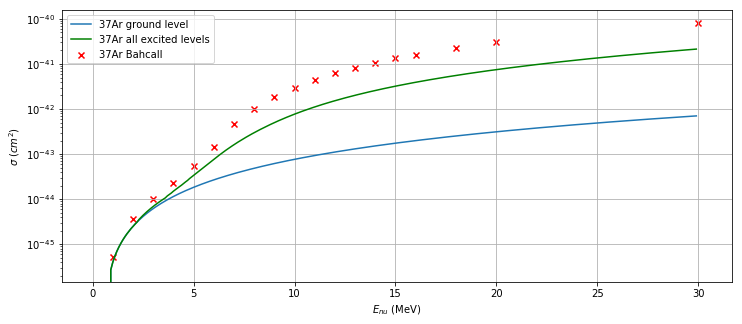

In [66]:
plt.figure(figsize=(12,5))
plt.plot(E_nu_list, sigma_37Ar, label='37Ar ground level')
plt.plot(E_nu_list, sigma_37Ar_full, c='green', label='37Ar all excited levels')
plt.scatter(Bachall['E_nu_Mev'], Bachall['Sigma_*10^42']*math.pow(10,-46), c='red',
            marker='x', label='37Ar Bahcall')
plt.legend()
plt.grid()
plt.xlabel('$E_{nu}$ (MeV)')
plt.ylabel('$\sigma$ $(cm^2)$')
plt.yscale('log')

## Подсчет для 76As

Считываем данные по энергии возбуждения $E_x$ и $J_\pi$

In [67]:
J_k_As = pd.read_csv('j_data_76As_minimal_values.csv') #для состояний с неизвестным J 
#считалось что J=0 
J_k_As.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
Elevel_(keV)    126 non-null float64
Jπ_korrect      126 non-null int64
dtypes: float64(1), int64(1)
memory usage: 2.0 KB


In [68]:
J_k_As_max = pd.read_csv('j_data_76As_maximal_values.csv')  #для состояний с неизвестным J 
#считалось что J=1
J_k_As_max.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
Elevel_(keV)    126 non-null float64
Jπ_korrect      126 non-null int64
dtypes: float64(1), int64(1)
memory usage: 2.0 KB


In [69]:
BGT=pd.read_csv('../B(GT) peaks processing/clear_B(GT).csv') #таблица со значениями B(GT)
BGT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 5 columns):
Unnamed: 0        73 non-null int64
Ex                73 non-null float64
Jpi               73 non-null object
diff cross-sec    73 non-null float64
B(GT)             73 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 2.9+ KB


In [70]:
fluxes=pd.read_csv('../Vyborov_results/Fluxes/SumFluxes.csv', sep=';')
fluxes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
energy          2000 non-null float64
sum_spectrum    2000 non-null float64
dtypes: float64(2)
memory usage: 31.3 KB


In [71]:
E_nu_list=fluxes['energy'].values
sum_spectrum=fluxes['sum_spectrum'].values
step_size=0.01 #MeV

In [78]:
#Зависимости сечения от энергии нейтрино для:
#метод Инжечика, первое возб. состояние, для состояний с неизвестным J считалось что J=0
Inzh_sigma_76As_1st=[sigma_k_Inzh(J_k_As['Jπ_korrect'][0], 0, E_nu, J_k_As['Elevel_(keV)'][0],
                         log_ft_76As, Z_76As, Q_EC_76As) for E_nu in E_nu_list]
#метод Инжечика, все возб. состояния, для состояний с неизвестным J считалось что J=0
Inzh_sigma_76As_all=[sum([sigma_k_Inzh(J_k, 0, E_nu, E_k, log_ft_76As, Z_76As, Q_EC_76As) for (J_k, E_k)
                      in zip(J_k_As['Jπ_korrect'].values, J_k_As['Elevel_(keV)'].values)])
                 for E_nu in E_nu_list]
#метод Иджири, все возб. состояния
Ej_sigma_76As_all=[sum([sigma_k_Ejiri(E_nu, E_k, BGT_k, Z_76As, Q_EC_76As) 
                            for (BGT_k, E_k) in zip(BGT['B(GT)'].values, BGT['Ex'].values)])
                 for E_nu in E_nu_list]
#метод Иджири, все возб. состояния, ферми-функция Бакала
Ej_sigma_76As_all_new=[sum([sigma_k_Ejiri_new(E_nu, E_k, BGT_k, Z_76As, Q_EC_76As) 
                            for (BGT_k, E_k) in zip(BGT['B(GT)'].values, BGT['Ex'].values)])
                 for E_nu in E_nu_list]
#метод Инжечика, все возб. состояния, ферми-функция Бакала, для состояний с неизвестным J 
#считалось что J=0
Inzh_sigma_76As_all_new=[sum([sigma_k_Inzh_new(J_k, 0, E_nu, E_k, log_ft_76As, Z_76As, Q_EC_76As) for (J_k, E_k)
                      in zip(J_k_As['Jπ_korrect'].values, J_k_As['Elevel_(keV)'].values)])
                 for E_nu in E_nu_list]
#метод Инжечика, все возб. состояния, для состояний с неизвестным J считалось что J=1
Inzh_sigma_76As_all_max=[sum([sigma_k_Inzh(J_k, 0, E_nu, E_k, log_ft_76As, Z_76As, Q_EC_76As) for (J_k, E_k)
                      in zip(J_k_As_max['Jπ_korrect'].values, J_k_As_max['Elevel_(keV)'].values)])
                 for E_nu in E_nu_list]

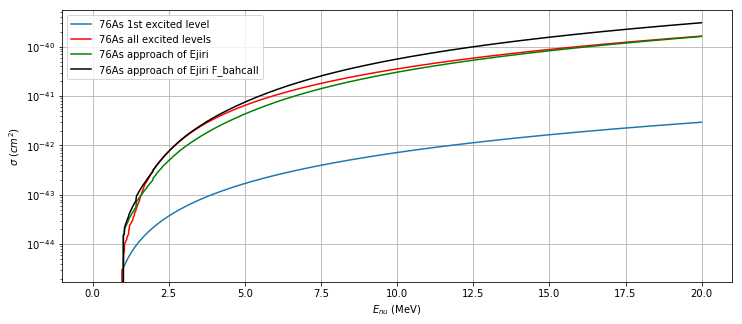

In [79]:
plt.figure(figsize=(12,5))
plt.plot(E_nu_list, Inzh_sigma_76As_1st, label='76As 1st excited level')
plt.plot(E_nu_list, Inzh_sigma_76As_all, c='red', label='76As all excited levels')
#plt.plot(E_nu_list, Inzh_sigma_76As_all_new, c='violet', label='76As all excited levels F_bahcall')
plt.plot(E_nu_list, Ej_sigma_76As_all, c='green', label='76As approach of Ejiri')
plt.plot(E_nu_list, Ej_sigma_76As_all_new, c='black', label='76As approach of Ejiri F_bahcall')
#plt.plot(E_nu_list, Ej_sigma_76As_all_new2, c='black', label='76As approach of Ejiri 2 F_bahcall')
plt.grid()
plt.legend()
plt.xlabel('$E_{nu}$ (MeV)')
plt.ylabel('$\sigma$ $(cm^2)$')
plt.yscale('log')
#plt.xscale('log')

## Подсчет $R=\sum_k\int{\rho_{solar}\sigma_kdE_\nu}$ в еденицах SNU
Делим на 3 для учета осцилляций; домножаем на math.pow(10,36) для получения значения в SNU

In [23]:
#метод Инжечика, все возб. состояния, для состояний с неизвестным J считалось что J=0
Inzh = ( sum(sum_spectrum*Inzh_sigma_76As_all*step_size) / 3 ) * math.pow(10,36)
print(Inzh)

108.122668634


In [24]:
#метод Инжечика, все возб. состояния, ферми-функция Бакала, для состояний с неизвестным J 
#считалось что J=0
Inzh_new = sum(sum_spectrum*Inzh_sigma_76As_all_new*step_size) / 3 * math.pow(10,36)
print(Inzh_new)

196.106073157


In [25]:
#метод Инжечика, все возб. состояния, для состояний с неизвестным J считалось что J=1
Inzh_max = sum(sum_spectrum*Inzh_sigma_76As_all_max*step_size) / 3 * math.pow(10,36)
print(Inzh_max)

201.472126672


In [26]:
#метод Иджири, все возб. состояния
Ejiri = sum(sum_spectrum*Ej_sigma_76As_all*step_size) / 3 * math.pow(10,36)
print(Ejiri)

22.7450733519


In [27]:
#метод Иджири, все возб. состояния, ферми-функция Бакала
Ejiri_new = sum(sum_spectrum*Ej_sigma_76As_all_new*step_size) / 3 * math.pow(10,36)
print(Ejiri_new)

40.8170863392


In [28]:
#учет pep
pep_ampl=1.453e8
pep_en=1.442 #MeV

Inzh_sigma_76As_all_pep=sum([sigma_k_Inzh(J_k, 0, pep_en, E_k, log_ft_76As, Z_76As, Q_EC_76As) for (J_k, E_k)
                      in zip(J_k_As['Jπ_korrect'].values, J_k_As['Elevel_(keV)'].values)])

print(pep_ampl*Inzh_sigma_76As_all_pep/3*math.pow(10,36))

10.8041217624


In [29]:
def oscillation(E_nu):
    return 0.336+0.117*np.exp((-E_nu-0.1)/4.82)+0.119*np.exp((-E_nu-0.1)/4.88)

In [41]:
def logft_calc(BGT):
    return np.log( 6127/(np.square(1.262*BGT)) )

In [32]:
sum(sum_spectrum*Ej_sigma_76As_all*step_size * oscillation(E_nu_list)) * math.pow(10,36)


26.141217072891333

In [52]:
logft=logft_calc(BGT['B(GT)'].values)
print('Ex', '\t', 'BGT_value', '\t', 'logft')
for (Ex, BGT_value, logft) in zip(BGT['Ex'].values, BGT['B(GT)'].values, logft):
    print(Ex, '\t', BGT_value, '\t', logft)

Ex 	 BGT_value 	 logft
86.0 	 1.2 	 7.8904218709
120.0 	 0.33 	 10.4723902335
265.0 	 0.1 	 12.8602351705
500.0 	 0.45 	 9.85208037692
513.8 	 0.71 	 8.94004560238
628.0 	 0.01 	 17.4654053565
744.0 	 0.02 	 16.0791109953
774.0 	 0.02 	 16.0791109953
864.0 	 0.25 	 11.0276537067
936.0 	 0.18 	 11.6846618407
1022.0 	 0.18 	 11.6846618407
1063.0 	 1.36 	 7.64009558499
1098.0 	 0.15 	 12.0493049543
1157.0 	 0.56 	 9.41470197499
1235.0 	 0.28 	 10.8009963361
1353.0 	 0.62 	 9.21113658637
1475.0 	 0.21 	 11.376360481
1540.0 	 0.03 	 15.2681807791
1573.0 	 0.09 	 13.0709562018
1637.0 	 0.03 	 15.2681807791
1693.0 	 0.49 	 9.68176476024
1718.0 	 0.13 	 12.3355066415
1792.0 	 0.13 	 12.3355066415
1852.0 	 0.33 	 10.4723902335
1902.0 	 0.45 	 9.85208037692
1929.0 	 0.04 	 14.6928166342
1987.0 	 0.1 	 12.8602351705
2041.0 	 0.06 	 13.881886418
2154.0 	 0.12 	 12.4955920569
2338.0 	 0.19 	 11.5765273981
2449.0 	 0.09 	 13.0709562018
2537.0 	 0.41 	 10.0382612231
2604.0 	 0.33 	 10.4723902335
2657